In [119]:
import tensorflow as tf
from tensorflow import keras
import os
import pandas as pd
import numpy as np
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import StandardScaler

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

Time Series Anomaly Detection with LSTM Autoencoders using Keras and TensorFlow2 in Python
by Venelin Valkov
https://curiousily.com/posts/anomaly-detection-in-time-series-with-lstms-using-keras-in-python/
https://github.com/curiousily/Deep-Learning-For-Hackers/blob/master/14.time-series-anomaly-detection.ipynb

In [127]:
def train_test_split(df, train_ratio):
    train_size = int(len(df) * train_ratio)
    train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
    return train, test


def scale_values(train, test, column):
    scaler = StandardScaler()
    scaler = scaler.fit(train[[column]])

    train[column] = scaler.transform(train[[column]])
    test[column] = scaler.transform(test[[column]])
    return train, test, scaler


def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])

    return np.array(Xs), np.array(ys)


def create_model(X_train):
    model = keras.Sequential()
    model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
    model.add(keras.layers.LSTM(
    units=64, 
    return_sequences=True))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.TimeDistributed(
        keras.layers.Dense(units=X_train.shape[2], activation="tanh")))
    model.compile(loss="mae", optimizer=keras.optimizers.Adam(learning_rate=0.001))
    return model


def train_auto_encoder(model, X_train, y_train):
    model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False)
    return model


def plot_training_loss(trained_model):
    plt.plot(trained_model.history.history["loss"], label="train")
    plt.plot(trained_model.history.history["val_loss"], label="test")
    plt.legend()

def predict(model, X):  # Varför en predict på data vi tränat på?
    return model.predict(X)

def mae_loss(X_pred, X):
    return np.mean(np.abs(X_pred, X), axis=1)

def plot_mae_loss(mae_loss):
    sns.distplot(mae_loss, bins=50, kde=True)


def create_test_score_df(test, time_steps, mae_loss, threshold, column):
    test_score_df = pd.DataFrame(index=test[time_steps:].index)
    test_score_df["loss"] = mae_loss
    test_score_df["threshold"] = threshold
    test_score_df["anomaly"] = test_score_df.loss > test_score_df.threshold
    test_score_df["water_level"] = test[time_steps:][column]
    return test_score_df

def plot_loss_with_threshold(df):
    plt.plot(df.index, df.loss, label="loss")
    plt.plot(df.index, df.threshold, label="threshold")
    plt.xticks(rotation=25)
    plt.legend()

def create_anomaly_df(df):
    return df[df.anomaly == True]


def plot_df_with_anomalies(df, time_steps, scaler, column, anomaly_df):
    plot_df(df, time_steps, scaler, column)
    scatter_anomalies(anomaly_df, scaler)

    plt.xticks(rotation=25)
    plt.legend()


def plot_df(df, time_steps, scaler, column):
    plt.plot(df[time_steps:].index,
    scaler.inverse_transform(df[time_steps:][column].values.reshape((-1, 1))),
    label="water level")    


def scatter_anomalies(anomaly_df, scaler):
    sns.scatterplot(x=anomaly_df.index,
    y=scaler.inverse_transform(anomaly_df.water_level.values.reshape((-1, 1))).flatten(),
    color=sns.color_palette()[3],
    s=52,
    label="anomaly")

def save_model():
    pass

In [ ]:
df = pd.read_csv("data/manipulated_data.csv", delimiter=";", header=3, index_col="Date/Time") 

train, test = train_test_split(df, 0.95)
train, test, scaler = scale_values(train, test, "Water level, Nap (cm)")

TIME_STEPS = 30

X_train, y_train = create_dataset(
    train[["Water level, Nap (cm)"]], 
    train[["Water level, Nap (cm)"]], 
    TIME_STEPS)

X_test, y_test = create_dataset(
    test[["Water level, Nap (cm)"]], 
    test[["Water level, Nap (cm)"]], 
    TIME_STEPS)

model = create_model(X_train)
model = train_auto_encoder(model, X_train, y_train)

In [ ]:
plot_training_loss(model)

In [ ]:
X_train_pred = predict(model, X_train)
train_mae_loss = mae_loss(X_train_pred, X_train)
plot_mae_loss(train_mae_loss)

In [ ]:
X_test_pred = predict(model, X_test)
test_mae_loss = mae_loss(X_test_pred, X_test)

THRESHOLD = 0.8
test_score_df = create_test_score_df(test, TIME_STEPS, test_mae_loss, THRESHOLD, "Water level, Nap (cm)")
plot_loss_with_threshold(test_score_df)

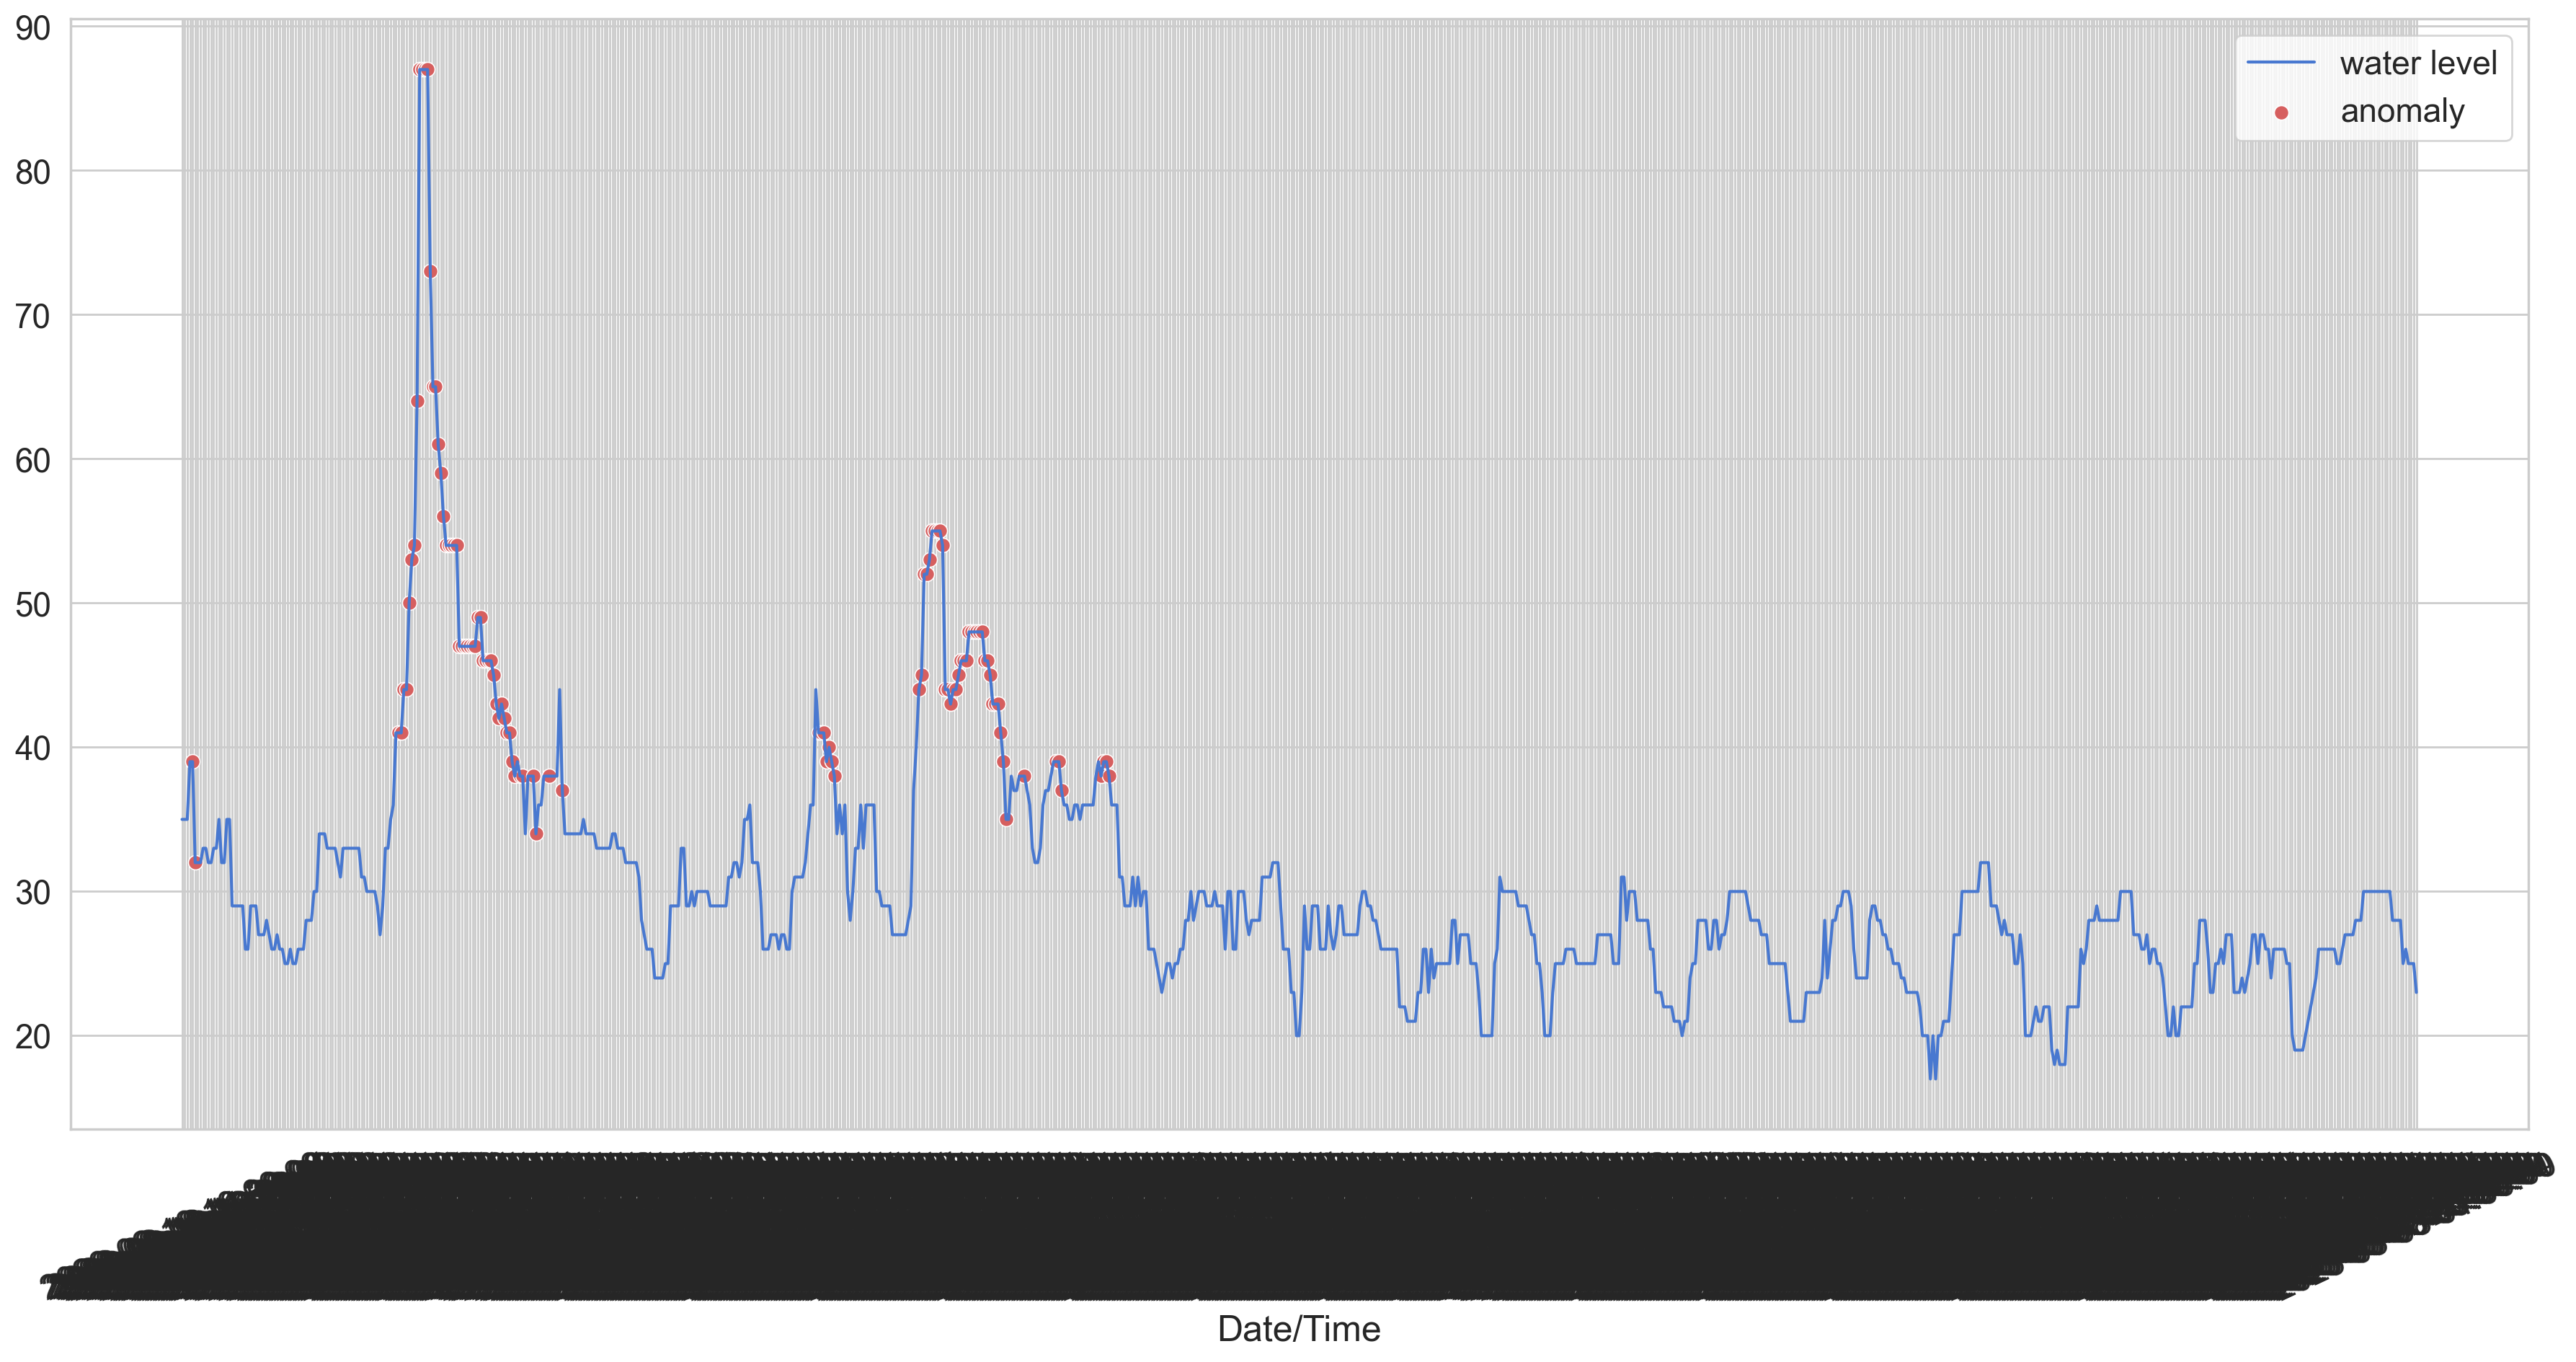

In [128]:
anomalies = create_anomaly_df(test_score_df)
plot_df_with_anomalies(test, TIME_STEPS, scaler, "Water level, Nap (cm)", anomalies)

In [27]:
""" # När vi skapar ett Sequentialobjekt, läggs alla layers på modellen i den ordning de kommer i koden.
model = keras.Sequential()

# LSTM har en minnescell så att modellen kommer ihåg vad som hänt tidigare i tidssekvensen.
# Den har tre portar: input, output samt forget, vilket gör det lättare att styra vilken information
# som ska flöda vidare. Den här modellen får nu 64 LSTM-celler.
model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])))

# Dropout slumpar 20% av värdena till 0 (alltså medelvärdet) för att minska risken för overfitting.
model.add(keras.layers.Dropout(rate=0.2))

# Det här lagret repeterar outputen av encodernätverket n antal gånger längs en ny axel, så tensor får 
# en till dimension med värdet från outputen * n(?).
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))

# Här returneras output från alla time steps i sekvensen. Default är False. Används ofta i mitten, sällan i slutet.
model.add(keras.layers.LSTM(
    units=64, 
    return_sequences=True))

model.add(keras.layers.Dropout(rate=0.2))

# TimeDistributed gör att lagret inuti appliceras på alla tidssteg oberoende av varandra.
model.add(keras.layers.TimeDistributed(
    # Dense-lagret tar output från LSTM och formar om till ny output av önskad storlek,
    # ofta(?) med en viktmatris, bias vector och genom en aktiveringsfunktion.
    keras.layers.Dense(units=X_train.shape[2], activation="tanh"
)))
# Här konfigureras inlärningsprocessen. Optimizern uppdaterar vikter under träning, loss mäter hur väl
# modellen presterar och metrics utvärderar hur väl modellen presterar.
# mae = mean absolute error, mäter hur nära det rätta resultatet modellen kommer. Ingen hänsyn tas till hur 
# stort felet är (absolute, not squared).
# Adam uppdaterar parametrarna, typ. :)
model.compile(loss="mae", optimizer=keras.optimizers.Adam(learning_rate=0.001)) """

In [ ]:
# Är det rimligt att den är så mycket sämre på testdelen 0.2536 (som är 5%) än träningsdelen 0.1099?
metrics_result = model.model.evaluate(X_test, y_test)
metrics_result.real